In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')
    

In [4]:
#================================================================================
# 一，讀取數據
#================================================================================
printlog("step1: reading data...")

# 讀取dftrain,dftest
breast = datasets.load_breast_cancer()
df = pd.DataFrame(breast.data,columns = [x.replace(' ','_') for x in breast.feature_names])
df['label'] = breast.target
dftrain,dftest = train_test_split(df)

xgb_train = xgb.DMatrix(dftrain.drop("label",axis = 1),dftrain[["label"]])
xgb_valid = xgb.DMatrix(dftest.drop("label",axis = 1),dftest[["label"]])


================================================================================2020-08-16 23:12:14
step1: reading data......




In [5]:
#================================================================================
# 二，設置參數
#================================================================================
printlog("step2: setting parameters...")
                               
num_boost_round = 100                   
early_stopping_rounds = 20

# 配置xgboost模型參數
params_dict = dict()

# booster參數
params_dict['learning_rate'] = 0.05      # 學習率，通常越小越好。
params_dict['objective'] = 'binary:logistic'

# tree參數
params_dict['max_depth'] = 3              # 樹的深度，通常取值在[3,10]之間
params_dict['min_child_weight']= 30       # 最小葉子節點樣本權重和，越大模型越保守。
params_dict['gamma']= 0                   # 節點分裂所需的最小損失函數下降值，越大模型越保守。
params_dict['subsample']= 0.8             # 橫向採樣，樣本採樣比例，通常取值在 [0.5，1]之間 
params_dict['colsample_bytree'] = 1.0     # 縱向採樣，特徵採樣比例，通常取值在 [0.5，1]之間 
params_dict['tree_method'] = 'hist'       # 構建樹的策略,可以是auto, exact, approx, hist

# regulazation參數 
# Omega(f) = gamma*T + reg_alpha* sum(abs(wj)) + reg_lambda* sum(wj**2)  
params_dict['reg_alpha'] = 0.0            #L1 正則化項的權重係數，越大模型越保守，通常取值在[0,1]之間。
params_dict['reg_lambda'] = 1.0           #L2 正則化項的權重係數，越大模型越保守，通常取值在[1,100]之間。

# 其他參數
params_dict['eval_metric'] = 'auc'
params_dict['silent'] = 1
params_dict['nthread'] = 2
params_dict['scale_pos_weight'] = 1       #不平衡樣本時設定為正值可以使算法更快收斂。
params_dict['seed'] = 0


================================================================================2020-08-16 23:12:15
step2: setting parameters......




In [6]:
#================================================================================
# 三，訓練模型
#================================================================================
printlog("step3: training model...")


result = {}
watchlist = [(xgb_train, 'train'),(xgb_valid,'valid')] 

bst = xgb.train(params = params_dict, dtrain = xgb_train, 
                num_boost_round = num_boost_round, 
                verbose_eval= 1,
                evals = watchlist,
                early_stopping_rounds=early_stopping_rounds,
                evals_result = result)


================================================================================2020-08-16 23:12:16
step3: training model......


[23:12:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.90633	valid-auc:0.88113
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.93149	valid-auc:0.92835
[2]	train-auc:0.93600	valid-auc:0.93280
[3]	train-auc:0.93638	valid-auc:0.93280
[4]	train-auc:0.96389	valid-auc:0.98589
[5]	train-auc:0.96395	valid-auc:0.98600
[6]	train-auc:0.96376	valid-auc:0.98600
[7]	train-auc:0.96438	valid-auc:0.98600
[8]	train-auc:0.97095


================================================================================2020-08-16 23:12:18
step4: evaluating model ......


train accuracy: 0.92723 
valid accuracy: 0.93706 



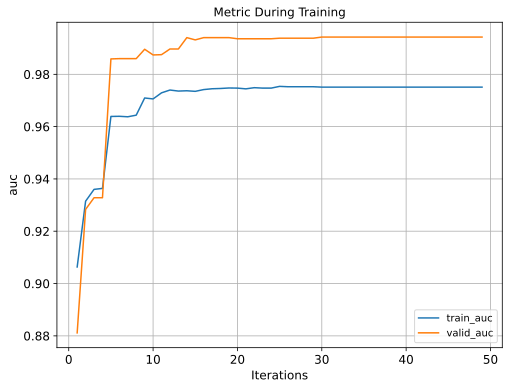

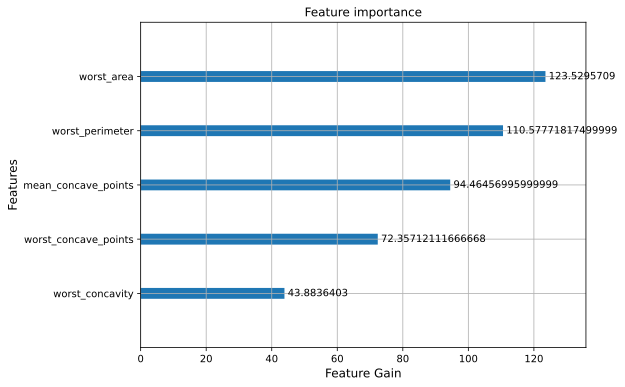

In [7]:
#================================================================================
# 四，評估模型
#================================================================================
printlog("step4: evaluating model ...")


y_pred_train = bst.predict(xgb_train, ntree_limit=bst.best_iteration)
y_pred_test = bst.predict(xgb_valid, ntree_limit=bst.best_iteration)

print('train accuracy: {:.5} '.format(accuracy_score(dftrain['label'], y_pred_train>0.5)))
print('valid accuracy: {:.5} \n'.format(accuracy_score(dftest['label'], y_pred_test>0.5)))

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

dfresult = pd.DataFrame({(dataset+'_'+feval): result[dataset][feval] 
               for dataset in ["train","valid"] for feval in ['auc']})

dfresult.index = range(1,len(dfresult)+1) 
ax = dfresult.plot(kind='line',figsize=(8,6),fontsize = 12,grid = True) 
ax.set_title("Metric During Training",fontsize = 12)
ax.set_xlabel("Iterations",fontsize = 12)
ax.set_ylabel("auc",fontsize = 12)


ax = xgb.plot_importance(bst,importance_type = "gain",xlabel='Feature Gain')
ax.set_xlabel("Feature Gain",fontsize = 12)
ax.set_ylabel("Features",fontsize = 12)
fig = ax.get_figure() 
fig.set_figwidth(8)
fig.set_figheight(6)


================================================================================2020-08-16 23:11:05
step1: reading data......



================================================================================2020-08-16 23:11:05
step2: setting parameters......



================================================================================2020-08-16 23:11:05
step3: training model......


[23:11:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.92670	valid-auc:0.87464
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.92670	valid-auc:0.874

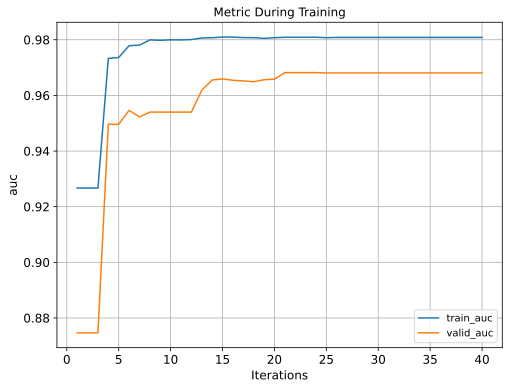

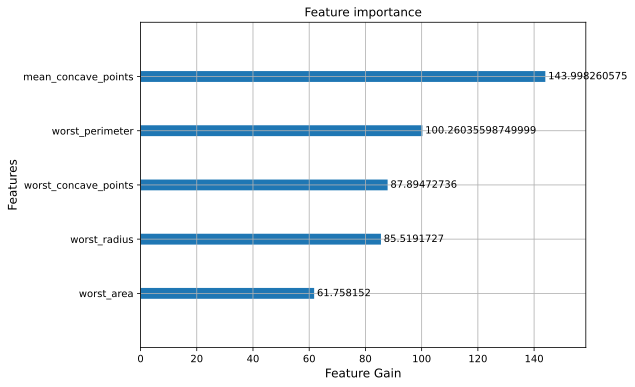

In [1]:
#================================================================================
# 五，保存模型
#================================================================================
printlog("step5: saving model ...")
model_dir = "data/bst.model"
print("model_dir: %s"%model_dir)
bst.save_model(model_dir)
bst_loaded = xgb.Booster(model_file=model_dir)

printlog("task end...")